Density-Based Clustering

Most of the traditional clustering techniques, such as k-means, hierarchical and fuzzy clustering, can be used to group data without supervision.

However, when applied to tasks with arbitrary shape clusters, or clusters within cluster, the traditional techniques might be unable to achieve good results. That is, elements in the same cluster might not share enough similarity or the performance may be poor. Additionally, Density-based Clustering locates regions of high density that are separated from one another by regions of low density. Density, in this context, is defined as the number of points within a specified radius.

In this section, the main focus will be manipulating the data and properties of DBSCAN and observing the resulting clustering.
Table of contents

    Clustering with Randomly Generated Data
        Data generation
        Modeling
        Distinguishing Outliers
        Data Visualization
    Weather Station Clustering with DBSCAN & scikit-learn
        Loading data
        Overview data
        Data cleaning
        Data selection
        Clustering
        Visualization of clusters based on location
        Clustering of stations based on their location, mean, max, and min Temperature
        Visualization of clusters based on location and Temperature

Import the following libraries:

    numpy as np
    DBSCAN from sklearn.cluster
    make_blobs from sklearn.datasets.samples_generator
    StandardScaler from sklearn.preprocessing
    matplotlib.pyplot as plt


Remember %matplotlib inline to display plots

In [1]:
# Notice: For visualization of map, you need basemap package.
# if you dont have basemap install on your machine, you can use the following line to install it
!conda install -c conda-forge  basemap==1.1.0  matplotlib==2.2.2  -y
# Notice: you maight have to refresh your page and re-run the notebook after installation

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
basemap                   1.1.0            py35h50ae964_7    conda-forge
matplotlib                2.2.2            py35h8e2386c_2    conda-forge


In [2]:
import numpy as np 
from sklearn.cluster import DBSCAN 
from sklearn.datasets.samples_generator import make_blobs 
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt 
%matplotlib inline

Data generation¶
The function below will generate the data points and requires these inputs:

    centroidLocation: Coordinates of the centroids that will generate the random data.
        Example: input: [[4,3], [2,-1], [-1,4]]
    numSamples: The number of data points we want generated, split over the number of centroids (# of centroids defined in centroidLocation)
        Example: 1500
    clusterDeviation: The standard deviation between the clusters. The larger the number, the further the spacing.
        Example: 0.5


In [3]:
def createDataPoints(centroidLocation, numSamples, clusterDeviation):
    # Create random data and store in feature matrix X and response vector y.
    X, y = make_blobs(n_samples=numSamples, centers=centroidLocation, 
                                cluster_std=clusterDeviation)
    
    # Standardize features by removing the mean and scaling to unit variance
    X = StandardScaler().fit_transform(X)
    return X, y

In [4]:
#Use createDataPoints with the 3 inputs and store the output into variables X and y.

X, y = createDataPoints([[4,3], [2,-1], [-1,4]] , 1500, 0.5)

Modeling
DBSCAN stands for Density-Based Spatial Clustering of Applications with Noise. This technique is one of the most common clustering algorithms which works based on density of object. The whole idea is that if a particular point belongs to a cluster, it should be near to lots of other points in that cluster.

It works based on two parameters: Epsilon and Minimum Points
Epsilon determine a specified radius that if includes enough number of points within, we call it dense area
minimumSamples determine the minimum number of data points we want in a neighborhood to define a cluster.


In [5]:
epsilon = 0.3
minimumSamples = 7
db = DBSCAN(eps=epsilon, min_samples=minimumSamples).fit(X)
labels = db.labels_
labels

array([0, 1, 2, ..., 1, 0, 1])

In [6]:
# First, create an array of booleans using the labels from db.
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
core_samples_mask


array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [7]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

3

In [8]:
# Remove repetition in labels by turning it into a set.
unique_labels = set(labels)
unique_labels

{0, 1, 2}

In [9]:
#Data visualization

# Create colors for the clusters.

colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

colors

array([[ 0.61960784,  0.00392157,  0.25882353,  1.        ],
       [ 0.99807766,  0.99923106,  0.74602076,  1.        ],
       [ 0.36862745,  0.30980392,  0.63529412,  1.        ]])

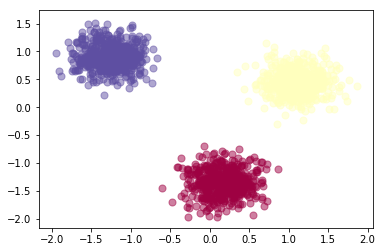

In [10]:
# Plot the points with colors
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    # Plot the datapoints that are clustered
    xy = X[class_member_mask & core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1],s=50, c=col, marker=u'o', alpha=0.5)

    # Plot the outliers
    xy = X[class_member_mask & ~core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1],s=50, c=col, marker=u'o', alpha=0.5)

Practice

To better underestand differences between partitional and density-based clusteitng, try to cluster the above dataset into 3 clusters using k-Means.
Notice: do not generate data again, use the same dataset as above.


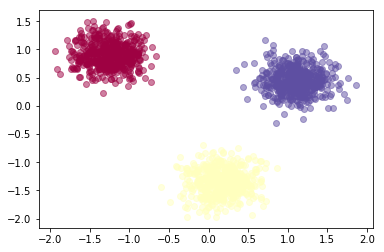

In [11]:
from sklearn.cluster import KMeans 
k = 3
k_means3 = KMeans(init = "k-means++", n_clusters = k, n_init = 12)
k_means3.fit(X)
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
for k, col in zip(range(k), colors):
    my_members = (k_means3.labels_ == k)
    plt.scatter(X[my_members, 0], X[my_members, 1],  c=col, marker=u'o', alpha=0.5)
plt.show()

 Weather Station Clustering using DBSCAN & scikit-learn

DBSCAN is specially very good for tasks like class identification on a spatial context. The wonderful attribute of DBSCAN algorithm is that it can find out any arbitrary shape cluster without getting affected by noise. For example, this following example cluster the location of weather stations in Canada.
DBSCAN can be used here, for instance, to find the group of stations which show the same weather condition. As you can see, it not only finds different arbitrary shaped clusters, can find the denser part of data-centered samples by ignoring less-dense areas or noises.

let's start playing with the data. We will be working according to the following workflow:
About the dataset
Environment Canada Monthly Values for July - 2015

Name in the table 	Meaning
Stn_Name 	Station Name
Lat 	Latitude (North+, degrees)
Long 	Longitude (West - , degrees)
Prov 	Province
Tm 	Mean Temperature (°C)
DwTm 	Days without Valid Mean Temperature
D 	Mean Temperature difference from Normal (1981-2010) (°C)
Tx 	Highest Monthly Maximum Temperature (°C)
DwTx 	Days without Valid Maximum Temperature
Tn 	Lowest Monthly Minimum Temperature (°C)
DwTn 	Days without Valid Minimum Temperature
S 	Snowfall (cm)
DwS 	Days without Valid Snowfall
S%N 	Percent of Normal (1981-2010) Snowfall
P 	Total Precipitation (mm)
DwP 	Days without Valid Precipitation
P%N 	Percent of Normal (1981-2010) Precipitation
S_G 	Snow on the ground at the end of the month (cm)
Pd 	Number of days with Precipitation 1.0 mm or more
BS 	Bright Sunshine (hours)
DwBS 	Days without Valid Bright Sunshine
BS% 	Percent of Normal (1981-2010) Bright Sunshine
HDD 	Degree Days below 18 °C
CDD 	Degree Days above 18 °C
Stn_No 	Climate station identifier (first 3 digits indicate drainage basin, last 4 characters are for sorting alphabetically).
NA 	Not Available
1-Download data¶
To download the data, we will use !wget to download it from IBM Object Storage.

In [12]:
!wget -O weather-stations20140101-20141231.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/weather-stations20140101-20141231.csv

--2018-12-11 22:20:56--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/weather-stations20140101-20141231.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129821 (127K) [text/csv]
Saving to: ‘weather-stations20140101-20141231.csv’

100%[======================================>] 129,821     --.-K/s   in 0.006s  

2018-12-11 22:20:56 (20.6 MB/s) - ‘weather-stations20140101-20141231.csv’ saved [129821/129821]



In [13]:
import csv
import pandas as pd
import numpy as np

filename='weather-stations20140101-20141231.csv'

#Read csv
pdf = pd.read_csv(filename)
pdf.head(5)

,Stn_Name,Lat,Long,Prov,Tm,DwTm,D,Tx,DwTx,Tn,...,DwP,P%N,S_G,Pd,BS,DwBS,BS%,HDD,CDD,Stn_No
0,CHEMAINUS,48.935,-123.742,BC,8.2,0.0,NaN,13.5,0.0,1.0,...,0.0,NaN,0.0,12.0,NaN,NaN,NaN,273.3,0.0,1011500
1,COWICHAN LAKE FORESTRY,48.824,-124.133,BC,7.0,0.0,3.0,15.0,0.0,-3.0,...,0.0,104.0,0.0,12.0,NaN,NaN,NaN,307.0,0.0,1012040
2,LAKE COWICHAN,48.829,-124.052,BC,6.8,13.0,2.8,16.0,9.0,-2.5,...,9.0,NaN,NaN,11.0,NaN,NaN,NaN,168.1,0.0,1012055
3,DISCOVERY ISLAND,48.425,-123.226,BC,NaN,NaN,NaN,12.5,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1012475
4,DUNCAN KELVIN CREEK,48.735,-123.728,BC,7.7,2.0,3.4,14.5,2.0,-1.0,...,2.0,NaN,NaN,11.0,NaN,NaN,NaN,267.7,0.0,1012573


In [14]:
#Clean the data - remove columns that do not have value in tm field
pdf = pdf[pd.notnull(pdf["Tm"])]
pdf = pdf.reset_index(drop=True)
pdf.head(5)

,Stn_Name,Lat,Long,Prov,Tm,DwTm,D,Tx,DwTx,Tn,...,DwP,P%N,S_G,Pd,BS,DwBS,BS%,HDD,CDD,Stn_No
0,CHEMAINUS,48.935,-123.742,BC,8.2,0.0,NaN,13.5,0.0,1.0,...,0.0,NaN,0.0,12.0,NaN,NaN,NaN,273.3,0.0,1011500
1,COWICHAN LAKE FORESTRY,48.824,-124.133,BC,7.0,0.0,3.0,15.0,0.0,-3.0,...,0.0,104.0,0.0,12.0,NaN,NaN,NaN,307.0,0.0,1012040
2,LAKE COWICHAN,48.829,-124.052,BC,6.8,13.0,2.8,16.0,9.0,-2.5,...,9.0,NaN,NaN,11.0,NaN,NaN,NaN,168.1,0.0,1012055
3,DUNCAN KELVIN CREEK,48.735,-123.728,BC,7.7,2.0,3.4,14.5,2.0,-1.0,...,2.0,NaN,NaN,11.0,NaN,NaN,NaN,267.7,0.0,1012573
4,ESQUIMALT HARBOUR,48.432,-123.439,BC,8.8,0.0,NaN,13.1,0.0,1.9,...,8.0,NaN,NaN,12.0,NaN,NaN,NaN,258.6,0.0,1012710


4-Visualization
Visualization of stations on map using basemap package. The matplotlib basemap toolkit is a library for plotting 2D data on maps in Python. Basemap does not do any plotting on it’s own, but provides the facilities to transform coordinates to a map projections.

Please notice that the size of each data points represents the average of maximum temperature for each station in a year.


In [16]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

llon=-140
ulon=-50
llat=40
ulat=65

pdf = pdf[(pdf['Long'] > llon) & (pdf['Long'] < ulon) & (pdf['Lat'] > llat) &(pdf['Lat'] < ulat)]

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
# my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To collect data based on stations        

xs,ys = my_map(np.asarray(pdf.Long), np.asarray(pdf.Lat))
pdf['xm']= xs.tolist()
pdf['ym'] =ys.tolist()

#Visualization1
for index,row in pdf.iterrows():
#   x,y = my_map(row.Long, row.Lat)
   my_map.plot(row.xm, row.ym,markerfacecolor =([1,0,0]),  marker='o', markersize= 5, alpha = 0.75)
#plt.text(x,y,stn)
plt.show()


KeyError: 'PROJ_LIB'

5- Clustering of stations based on their location i.e. Lat & Lon¶
DBSCAN form sklearn library can runs DBSCAN clustering from vector array or distance matrix.
In our case, we pass it the Numpy array Clus_dataSet to find core samples of high density and expands clusters from them. 

In [17]:
set(labels)

{0, 1, 2}

6- Visualization of clusters based on location
Now, we can visualize the clusters using basemap: 

In [18]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
#my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To create a color map
colors = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))



#Visualization1
for clust_number in set(labels):
    c=(([0.4,0.4,0.4]) if clust_number == -1 else colors[np.int(clust_number)])
    clust_set = pdf[pdf.Clus_Db == clust_number]                    
    my_map.scatter(clust_set.xm, clust_set.ym, color =c,  marker='o', s= 20, alpha = 0.85)
    if clust_number != -1:
        cenx=np.mean(clust_set.xm) 
        ceny=np.mean(clust_set.ym) 
        plt.text(cenx,ceny,str(clust_number), fontsize=25, color='red',)
        print ("Cluster "+str(clust_number)+', Avg Temp: '+ str(np.mean(clust_set.Tm)))

KeyError: 'PROJ_LIB'

7- Clustering of stations based on their location, mean, max, and min Temperature
In this section we re-run DBSCAN, but this time on a 5-dimensional dataset: 

In [19]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)
Clus_dataSet = pdf[['xm','ym','Tx','Tm','Tn']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
pdf["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


# A sample of clusters
pdf[["Stn_Name","Tx","Tm","Clus_Db"]].head(5)

KeyError: "['xm' 'ym'] not in index"

8- Visualization of clusters based on location and Temperature

In [20]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
#my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To create a color map
colors = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))



#Visualization1
for clust_number in set(labels):
    c=(([0.4,0.4,0.4]) if clust_number == -1 else colors[np.int(clust_number)])
    clust_set = pdf[pdf.Clus_Db == clust_number]                    
    my_map.scatter(clust_set.xm, clust_set.ym, color =c,  marker='o', s= 20, alpha = 0.85)
    if clust_number != -1:
        cenx=np.mean(clust_set.xm) 
        ceny=np.mean(clust_set.ym) 
        plt.text(cenx,ceny,str(clust_number), fontsize=25, color='red',)
        print ("Cluster "+str(clust_number)+', Avg Temp: '+ str(np.mean(clust_set.Tm)))

KeyError: 'PROJ_LIB'